# Task Summary

* Problem: need a way to automatically categorize articles to provide proper filtering functionality
* Task: multi-class classification of articles
* Output required:
    * Exploratory analysis of data
    * Solution explaination
    * Documentation of results
    * Training and evaluation code

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib. pyplot as plt
import numpy as np

%matplotlib inline

# Data overview

In [4]:
# read data
df = pd.read_csv("data/raw/data_redacted.tsv", delimiter='\t')
print(df.shape)

(8646, 4)


,title,text,url,category
0,"Don""t Mourn the Y Chromosome","The human Y chromosome may vanish one day, but...",http://discovermagazine.com/2014/nov/13-y-not,technology_science
1,Destiny: Bungie to introduce ammo pack micro-t...,Bungie is putting together plans to start sell...,http://www.ibtimes.co.uk/destiny-bungie-introd...,digital_life
2,Daruvala to race for Josef Kaufmann Racing in ...,Highly rated Jehan Daruvala will race for Jose...,http://www.thecheckeredflag.co.uk/2015/12/daru...,sports


In [7]:
# null values
df.isnull().sum()

title       0
text        0
url         0
category    0
dtype: int64

### Target variable

fashion_beauty_lifestyle    0.161693
sports                      0.134744
technology_science          0.120287
digital_life                0.085357
money_business              0.084779
news                        0.074717
music                       0.065695
culture                     0.063266
travel                      0.062919
cars_motors                 0.054360
politics                    0.049734
people_shows                0.042447
Name: category, dtype: float64


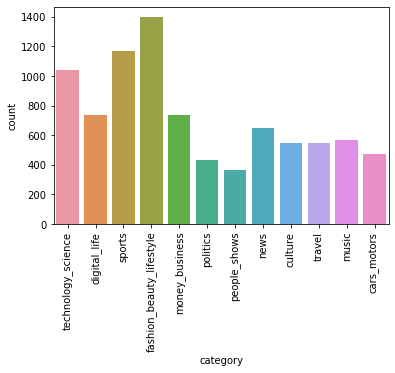

In [5]:
# target variable
print(df.category.value_counts() / len(df))

sns.countplot(df.category)
plt.xticks(rotation=90)
plt.show()

* 3 text features (`title`,`text`,`url`)
* 12 unique categories
    * imbalanced: for example, there are 4 times more `fashion_beauty_lifecycle` (`16%`) articles as `people_shows` (`4%`) articles

### Text data

In [10]:
# looking at example articles
for cat in df.category.unique():
    print(f"Example of category {cat}:")
    sample = df[df.category==cat].sample(1)
    print(sample.title.values[0], sample.url.values[0])
    print(sample.text.values[0][:500],end= "\n\n")

Example of category technology_science:
Omega-3 Fatty Acids Reduce Risk of Fatal Heart Attack http://www.livescience.com/55198-omega-3-fatty-acids-reduce-fatal-heart-attacks.html
Eating fish, nuts, seeds and plants with omega-3 fatty acids may significantly lower your risk of dying from a heart attack, according to the most thorough study to date on this contested nutritional topic. Previous research on fish oil supplements and other sources of omega-3 fatty acids has shown mixed results, with some studies revealing heart-healthy benefits and others finding no benefit at all. The latest research, reported today (June 27) in the journal JAMA Internal Medicine, was the lar

Example of category digital_life:
Halo 5: Guardians; Driveclub: Bikes; WWE 2K16, gaming reviews http://www.independent.co.uk/life-style/gadgets-and-tech/gaming/halo-5-guardians-driveclub-bikes-wwe-2k16-gaming-reviews-a6722731.html
A storyline so complex you need a PHD in cosmology to understand things Halo 5: Guardian

Some decisions for data preprocessing:
* punctuations: while most punctuations can be removed, Some punctuations I think could benefit the prediction. For example `$` is probably used a lot more in `money_business` than `sports`.
* stopwords: stopwords should be removed since they do not add value in this case

In [11]:
from string import punctuation
all_punc = list(punctuation) + ['’','‘']
incl_pun = ['$','%','!','?']

# stopwords
from nltk.corpus import stopwords  
stopwords = list(stopwords.words('english'))
for pun in list(set(all_punc) - set(incl_pun)):
    stopwords = [i.replace(pun,'') for i in stopwords]

def clean_text(text,all_punc,incl_pun,stopwords):
    # remove pun
    for pun in list(set(all_punc) - set(incl_pun)):
        if pun in text:
            text = text.replace(pun,"")
    # add white space to allowed punctuations for tokenization
    for pun in incl_pun:
        if pun == '$':
            text = text.replace(pun, "$ ")
        else:
            text = text.replace(pun, f" {pun}")
    
    # lower case & tokenize & stopwords
    return [t for t in text.lower().split() if t not in stopwords]

# creating tokenized dataset
df_clean = df.copy()
for t in ['title','text']:
    df_clean[f'{t}_cleaned'] = [clean_text(i,all_punc,incl_pun,stopwords) for i in df_clean[t]]
    df_clean[f'{t}_cleaned_len'] = [len(i) for i in df_clean[f'{t}_cleaned']]
    df_clean[f'{t}_cleaned_unique_len'] = [len(np.unique(i)) for i in df_clean[f'{t}_cleaned']]
    df_clean[f'{t}_cleaned_unique_share'] = df_clean[f'{t}_cleaned_unique_len'] / df_clean[f'{t}_cleaned_len']
    df_clean.drop(t,axis=1,inplace=True)

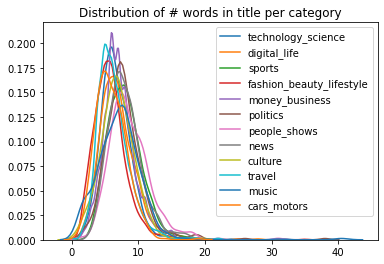

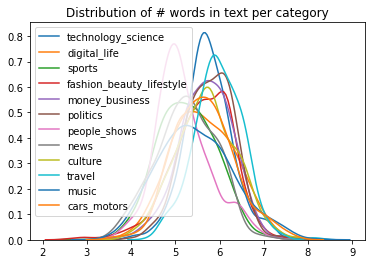

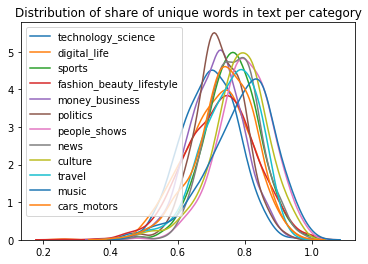

In [16]:
for cat in df_clean.category.unique():
    sns.distplot([i for i in df_clean[df_clean.category == cat].title_cleaned_len],bins=100,hist=False,label=cat)
plt.legend()
plt.title("Distribution of # words in title per category")
plt.show()

for cat in df_clean.category.unique():
    sns.distplot([np.log(i) for i in df_clean[df_clean.category == cat].text_cleaned_len],bins=100,hist=False,label=cat)
plt.legend()
plt.title("Distribution of # words in text per category")
plt.show()


for cat in df_clean.category.unique():
    sns.distplot([i for i in df_clean[df_clean.category == cat].text_cleaned_unique_share],bins=100,hist=False,label=cat)
plt.legend()
plt.title("Distribution of share of unique words in text per category")
plt.show()


In [28]:
# looking at overlaps per category to see if tok based classification will have problems
all_text_vocab = dict()
for cat in df_clean.category.unique():
    tmp = []
    for tc in df_clean[df_clean.category == cat].text_cleaned:
        tmp += tc
    all_text_vocab[cat] = list(set(tmp))

    corr = pd.DataFrame()
import itertools
for topic_pair in itertools.permutations(df_clean.category.unique(),2):
    a = all_text_vocab[topic_pair[0]]
    b = all_text_vocab[topic_pair[1]]
    inter = set(a).intersection(b)
    corr = pd.concat([corr,pd.DataFrame([topic_pair[0],topic_pair[1],len(inter)]).transpose()],axis=0)

for cat in df_clean.category.unique():
    corr = pd.concat([corr,pd.DataFrame([cat,cat,len(all_text_vocab[cat])]).transpose()],axis=0)
    
corr.columns = ['cat_a','cat_b','intersection']
corr.intersection = corr.intersection.astype(int)

corr_pivoted = corr.pivot('cat_a','cat_b','intersection')
for s in corr_pivoted:
    corr_pivoted[s] = corr_pivoted[s] / corr_pivoted[s][s]

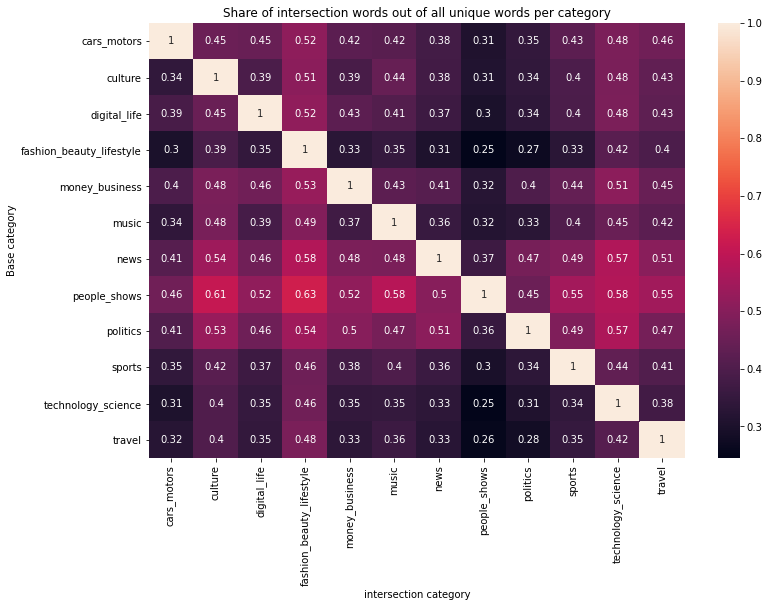

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(corr_pivoted.transpose(),annot=True)
plt.title("Share of intersection words out of all unique words per category")
plt.ylabel("Base category")
plt.xlabel("intersection category")
plt.show()

* There are some differences in distribution of number of words per category, but not too distinctive (lots of overlap)
* Highly specific categories have lower overlap in tokens compared to more general categories. For example, `technology_science` has one of the lowest intersection tokens / unique category tokens share ranging around 25%\~40%, while `news` has a higher share ranging from 40%\~60%. This shows that token level is already enough to distinguish different category articles

### URL data

In [24]:
# parsing urls
from urllib.parse import urlparse
df_clean['url_cleaned'] = [urlparse(i).netloc.replace("www.","").split(".co")[0] for i in df_clean.url]

print(f"Unique url present: {len(df_clean.url_cleaned.unique())} ({np.round(len(df_clean.url_cleaned.unique()) / len(df_clean) * 100,1)}%)")

Unique url present: 1325 (15.3%)


In [49]:
# number of unique categories by url
print(f"Unique categories by main url:")
print(df_clean.groupby('url_cleaned').category.nunique().describe())

print(f"Main urls with only a single category")
print(len(df_clean.groupby('url_cleaned').category.nunique()[df_clean.groupby(['url_cleaned']).category.nunique() == 1]))
print(len(df_clean.groupby('url_cleaned').category.nunique()[df_clean.groupby(['url_cleaned']).category.nunique() == 1]) / 1325)

print(f"\nUnique categories by main url with more than one category:")
print(df_clean.groupby('url_cleaned').category.nunique()[df_clean.groupby(['url_cleaned']).category.nunique() > 1].describe())

Unique categories by main url:
count    1325.000000
mean        1.444528
std         1.336557
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        12.000000
Name: category, dtype: float64
Main urls with only a single category
1062
0.8015094339622642

Unique categories by main url with more than one category:
count    263.000000
mean       3.239544
std        2.234282
min        2.000000
25%        2.000000
50%        2.000000
75%        3.000000
max       12.000000
Name: category, dtype: float64


* 80%+ of the urls only have a single corresponding category, which means using this feature may lead to overfitting if used in the raw form. If somehow condensed however, it could be a very powerful predictive feature
* The other 20% also had on average roughly around 2 unique categories

# Feature engineering & Training

The feature engineering and training are done via the python file `train_data.py`. The saved model is in the `model/` directory.

Summary of decisions made:
* Data:
    * Title and text data were combined together. They were also trained separately but this created too many features with no added value. Also, titles are mostly just a summary of text data so most likely not a lot of information is lost by combining the 2 text sources
    * url data was removed due to the possible overfitting problem (a lot of single article urls) 
    * some meta-data were used (# of tokens), but with log transformation as text lengths can get quite large and vary quite a lot
* Tf-idf vectorizer was used to vectorize text data on a token level. Intersection graph of unique terms showed that word level already allows for some distinction among categories. Raw count vectorizer was also compared (as Multinomial Naive Bayes is originall intended for raw counts (integer)), but results were better with Tf-idf. Tokens covering less than 1% of the documents were removed to only include tokens that can be used a useful feature.
* Model:
    * Multinomial Naive Bayes was used for (1) simplicity and (2) limited data available that makes trying more complex models an over-kill. NB also is known to perform well for general text classification tasks, especially when sequence/order of text is not important (independent features).
    * `alpha` value for MNB model was selected based on gridsearch results
    * cross validation results show that while for training evaluation metrics (precision, recall, f1) are constant with standard deviations almost close to 0, the standard deviations for test range from 1~2%. This slight overfit may be due to extreme number of features compared to the samples available
* Evaluation metrics: precision, recall, and f1 were compared by category. Since there is an imbalance in classes, it is more important to look at individual performances rather than overall metric. 

# Evaluation

In [33]:
# import from evaluation py file
from evaluate_results import get_prediction,evaluate_results

In [34]:
import pickle
# read in model and data
mnb = pickle.load(open("model/mnb_model.pkl",'rb'))
y_encoder = pickle.load(
    open("model/y_encoder.pkl",'rb'))

# load preprocessed train and test data
X_train = pd.read_csv("data/processed/X_train_processed.csv")
X_test= pd.read_csv("data/processed/X_test_processed.csv")
y_train = np.load("data/processed/y_train_enc.npy")
y_test = np.load("data/processed/y_test_enc.npy")

In [35]:
# get prediction and metrics
train_pred = get_prediction(mnb,X_train,y_train,y_encoder)
test_pred = get_prediction(mnb,X_test,y_test,y_encoder)
train_metrics = evaluate_results(train_pred,y_encoder)
test_metrics = evaluate_results(test_pred,y_encoder)

In [41]:
print("Train results summary")
train_metrics.describe()

Train results summary


,precision,recall,fscore,support
count,12.000000,12.000000,12.000000,12.000000
mean,0.894769,0.898955,0.896489,648.416667
std,0.044044,0.038095,0.036638,287.413373
min,0.841492,0.857143,0.849829,330.000000
25%,0.862182,0.868673,0.879243,473.250000
50%,0.888674,0.889363,0.883535,546.000000
75%,0.929982,0.917601,0.913973,732.000000
max,0.975938,0.966635,0.971264,1258.000000


In [42]:
print("Test results summary")
test_metrics.describe()

Test results summary


,precision,recall,fscore,support
count,12.000000,12.000000,12.000000,12.000000
mean,0.881014,0.875624,0.876959,72.083333
std,0.047146,0.065426,0.044436,31.861799
min,0.800000,0.756757,0.777778,37.000000
25%,0.855016,0.820285,0.864476,52.250000
50%,0.865799,0.887302,0.868911,61.000000
75%,0.915428,0.914275,0.902041,81.500000
max,0.951613,0.964912,0.948276,140.000000


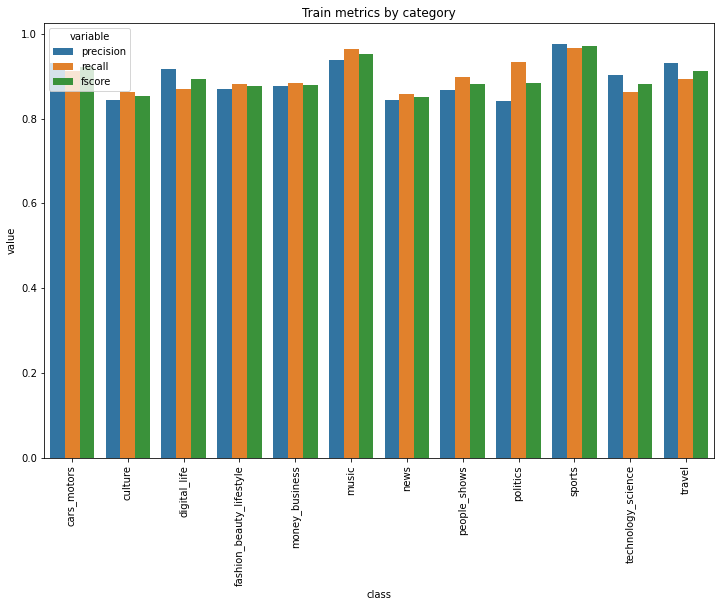

,class,precision,recall,fscore,support
0,cars_motors,0.930120,0.912530,0.921241,423
1,culture,0.844622,0.861789,0.853119,492
2,digital_life,0.917460,0.870482,0.893354,664
3,fashion_beauty_lifestyle,0.870588,0.882353,0.876431,1258
4,money_business,0.875562,0.884848,0.880181,660
5,music,0.939048,0.964775,0.951737,511
6,news,0.842640,0.857143,0.849829,581
7,people_shows,0.868035,0.896970,0.882265,330
8,politics,0.841492,0.932817,0.884804,387
9,sports,0.975938,0.966635,0.971264,1049


In [43]:
plt.figure(figsize=(12,8))
sns.barplot(data= pd.melt(train_metrics,id_vars='class',value_vars=['precision','recall','fscore']),
            x = 'class',y='value',hue='variable')
plt.title("Train metrics by category")
plt.xticks(rotation =90)
plt.show()

train_metrics

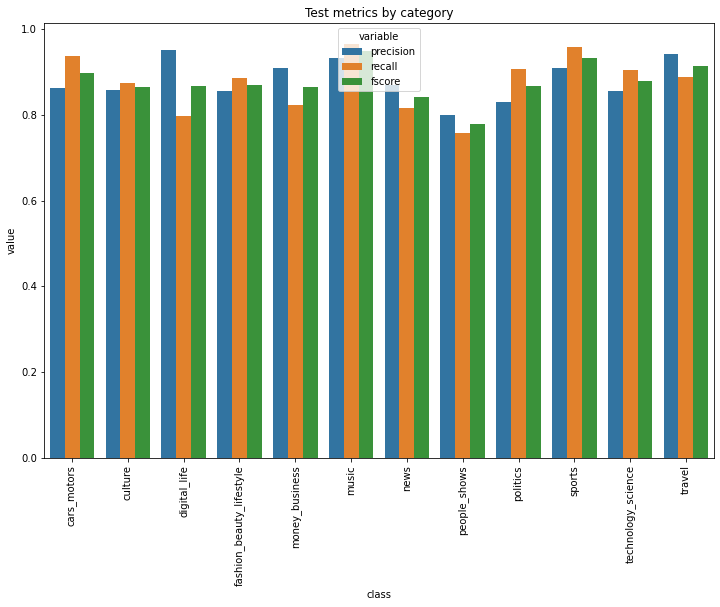

,class,precision,recall,fscore,support
0,cars_motors,0.862745,0.936170,0.897959,47
1,culture,0.857143,0.872727,0.864865,55
2,digital_life,0.951613,0.797297,0.867647,74
3,fashion_beauty_lifestyle,0.855172,0.885714,0.870175,140
4,money_business,0.909091,0.821918,0.863309,73
5,music,0.932203,0.964912,0.948276,57
6,news,0.868852,0.815385,0.841270,65
7,people_shows,0.800000,0.756757,0.777778,37
8,politics,0.829787,0.906977,0.866667,43
9,sports,0.909836,0.956897,0.932773,116


In [44]:
plt.figure(figsize=(12,8))
sns.barplot(data= pd.melt(test_metrics,id_vars='class',value_vars=['precision','recall','fscore']),
            x = 'class',y='value',hue='variable')
plt.title("Test metrics by category")
plt.xticks(rotation =90)
plt.show()

test_metrics

* Overall result does not look bad with hold out data (test) data. Recall seems to suffer a little and also have a wider standard deviation.
* Higher performance in highly specific categories like `sports` or `cars_motors` and lower performance in more general categories like `news` or `people_shows`. The former categories probably have specicfic terms not used in other topics. On the other hand, `people_shows` may also be suffering simply due to lack of data compared to other categories as well.

# Future considerations

* Possible use of pre-trained embeddings for embedding text features
* Inclusion of url data (clustering of url based on historically seen article categories?)
* Feature reduction methods: PCA
* Neural network architecture with more data